[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeyabbalas/makemore/blob/main/mlp2.ipynb)

# Makemore - MLP 2 (initialization and normalization)

This notebook continues the MLP example from the previous notebook, where we implemented the MLP from [(Bengio et al., 2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). We will try to understand the importance of good initialization and normalization. This will help us prepare for training RNNs since they are not easily optimizable.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random
import requests

seed = 1234
random.seed(seed)

## Prepare the cross-validation datasets

In [2]:
url = "https://raw.githubusercontent.com/jeyabbalas/makemore/main/names.txt"
names = requests.get(url).text.split("\n")

print(names[:10])
print(f"Total number of names: {len(names):,}")

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Total number of names: 32,033


In [3]:
vocab = ["."] + sorted(set([char for name in names for char in name]))
char_to_ix = {char: ix for ix, char in enumerate(vocab)}
ix_to_char = {ix: char for ix, char in enumerate(vocab)}
vocab

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [4]:
def build_dataset(words, block_size=3):
    X, Y = [], []
    
    for word in words:
        context = [0] * block_size
        for char in word + ".":
            X.append(context)
            ix = char_to_ix[char]
            Y.append(ix)
            context = context[1:] + [ix]
    
    return torch.tensor(X), torch.tensor(Y)

In [5]:
random.shuffle(names)

train_names = names[:int(0.8 * len(names))]
val_names = names[int(0.8 * len(names)):int(0.9 * len(names))]
test_names = names[int(0.9 * len(names)):]

X_train, Y_train = build_dataset(train_names)
X_val, Y_val = build_dataset(val_names)
X_test, Y_test = build_dataset(test_names)

print(f"{X_train.shape=}, {Y_train.shape=}")
print(f"{X_val.shape=}, {Y_val.shape=}")
print(f"{X_test.shape=}, {Y_test.shape=}")

X_train.shape=torch.Size([182542, 3]), Y_train.shape=torch.Size([182542])
X_val.shape=torch.Size([22823, 3]), Y_val.shape=torch.Size([22823])
X_test.shape=torch.Size([22781, 3]), Y_test.shape=torch.Size([22781])


## Define the model

In [6]:
# Model definition
rng = torch.Generator().manual_seed(seed)

## Hyperparameters
block_size = 3
embed_dim = 10
hidden_units = 200

## Parameters
### Embedding layer
C = torch.randn(len(vocab), embed_dim, generator=rng, requires_grad=True)
### Hidden layer
W1 = torch.randn(embed_dim * block_size, hidden_units, generator=rng, requires_grad=True)
b1 = torch.randn(hidden_units, generator=rng, requires_grad=True)
### Output layer
W2 = torch.randn(hidden_units, len(vocab), generator=rng, requires_grad=True)
b2 = torch.randn(len(vocab), generator=rng, requires_grad=True)

parameters = [C, W1, b1, W2, b2]
print(f"Total number of parameters in the MLP: {sum(p.numel() for p in parameters):,}")

Total number of parameters in the MLP: 11,897


## Optimization

      1 / 200,000: 26.4691
 10,001 / 200,000: 2.7524
 20,001 / 200,000: 3.2179
 30,001 / 200,000: 2.8675
 40,001 / 200,000: 3.2573
 50,001 / 200,000: 2.6165
 60,001 / 200,000: 3.1160
 70,001 / 200,000: 2.6647
 80,001 / 200,000: 3.7915
 90,001 / 200,000: 2.3548
100,001 / 200,000: 2.9391
110,001 / 200,000: 2.0492
120,001 / 200,000: 2.0659
130,001 / 200,000: 2.7226
140,001 / 200,000: 2.2520
150,001 / 200,000: 2.1324
160,001 / 200,000: 2.0189
170,001 / 200,000: 1.7030
180,001 / 200,000: 2.4560
190,001 / 200,000: 2.0513


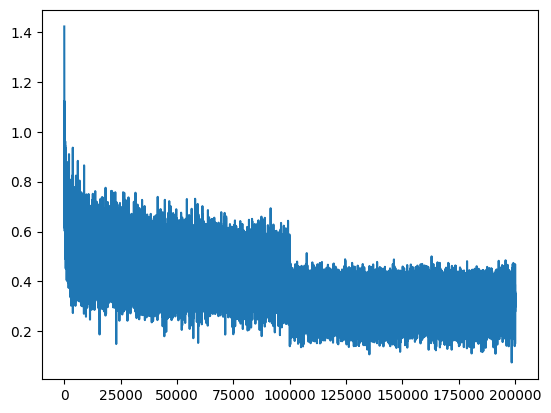

In [7]:
max_steps = 200_000
batch_size = 32

loss_train_i = []
h_pre_active_init = None
h_init = None

for i in range(max_steps):
    # Minibatch
    idx_batch = torch.randint(0, len(X_train), (batch_size,))
    X, Y = X_train[idx_batch], Y_train[idx_batch]

    # Forward pass
    embed = C[X]  # embed characters into vectors (num_examples, block_size, embed_dim)
    embed_concat = embed.view(len(embed), -1)  # concatenate the vectors (num_examples, block_size * embed_dim)
    h_pre_active = embed_concat @ W1 + b1  # hidden layer pre-activation (num_examples, hidden_units)
    h = torch.tanh(h_pre_active)  # hidden layer activation (num_examples, hidden_units)
    logits = h @ W2 + b2  # output layer (num_examples, len(vocab))
    loss = F.cross_entropy(logits, Y)  # cross-entropy loss

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    learning_rate = 10**-0.5 if i < 100_000 else 10**-1.5  # learning rate decay schedule
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # Track performance
    if i % 10_000 == 0:
        if i == 0:
            h_pre_active_init = h_pre_active.detach().clone()
            h_init = h.detach().clone()
        print(f"{i+1:7,d} / {max_steps:7,d}: {loss.item():.4f}")
    loss_train_i.append(loss.log10().item())

# Plot convergence
plt.plot(loss_train_i)

## Evaluation

In [8]:
@torch.no_grad()  # disable gradient tracking; alternative to `with torch.no_grad():`
def cv_split_loss(split_name='train'):
    X, Y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split_name]
    
    embed = C[X]
    embed_concat = embed.view(len(embed), -1)
    h = torch.tanh(embed_concat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    
    print(f"{split_name.capitalize()} set loss: {loss.item():.4f}")

In [9]:
cv_split_loss('train')
cv_split_loss('val')

Train set loss: 2.0782
Val set loss: 2.1476


## Generate names

In [10]:
rng = torch.Generator().manual_seed(seed)
num_names = 10

for _ in range(num_names):
    name = []
    context = [0] * block_size
    while True:
        # Forward pass
        embed = C[torch.tensor([context])]
        h = torch.tanh(embed.view(-1, block_size * embed_dim) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=-1)
        
        # Sample the next character
        next_char_ix = torch.multinomial(probs[-1], num_samples=1, generator=rng).item()
        
        # Update the context
        context = context[1:] + [next_char_ix]
        name.append(ix_to_char[next_char_ix])
        
        if next_char_ix == 0:  # stop when the end-of-name character is sampled
            break
    
    print("".join(name))

kendayvidahrisie.
rendar.
matazzyiah.
reuter.
oso.
lis.
bowan.
callen.
ryeasty.
don.


## Initialization: 

### Overconfident logits problem
1. You must always have a rough idea of what the initial loss should be. Here, the initial loss (before training) is too high. 
2. The expected initial loss should be around $-\log\Bigg(\frac{1}{\text{len}(\text{vocab})}\Bigg) = -\log\Bigg(\frac{1}{27}\Bigg) = 3.2958$, i.e. the cross-entropy loss of a uniformly assigned output distribution. Such a model confesses to be ignorant about the correct class.
3. The "hockey stick" like shape of the loss curve is a sign of poor initialization. The initial stages of learning is important but is wasted in just learning to squash the logits to a fairly uniform distribution. This is something we already know so, we can initialize more intelligently.
4. You may notice some improvement because the initial stages are now being used for some non-trivial learning.

In [11]:
# Example of poor initialization
rng = torch.Generator().manual_seed(seed)
vocab_size = 4
correct_class_ix = 2

logits = torch.randn(vocab_size, generator=rng) * 10
#logits = torch.zeros(vocab_size)  # good initialization (uniform distribution)
probs = F.softmax(logits, dim=-1)
loss = -probs[correct_class_ix].log()

print(f"Expected loss: {-(1 / torch.tensor(vocab_size)).log().item():.4f}")
print(f"Initial loss: {loss.item():.4f}")

Expected loss: 1.3863
Initial loss: 14.3087


### Neuron saturation problem
1. The hidden layer is using the tanh activation function. The tanh function saturates at $\pm 1$. 
$$
\frac{d\text{tanh}(x)}{dx} = 1 - \text{tanh}^2(x)
$$

2. **Vanishing gradient problem**:
    - If $\text{tanh}(x)=\pm 1$, $1 - \text{tanh}^2(x)=0$. Since the gradient is zero, the neuron kills all gradients from passing through it. Small changes to the activations result in no change in the loss because the activations stay in the saturated region.
    - If $\text{tanh}(x)=0$, $1 - \text{tanh}^2(x)=1$. Since the gradient is one, the neuron does not change the gradient. The gradient from the later layers is just passed through unaltered. This is, in fact, the best case scenario.
    - For all other values of $\text{tanh}(x)$, $1 - \text{tanh}^2(x) \in (0, 1)$. The gradient is scaled down by a factor of $1 - \text{tanh}^2(x)$. So, when the gradient is not killed or passed through unaltered, it is always mitigated. It is never increased.

3. A vast majority of neural activations lie in the saturated region. Small changes to the activations result in no change in the loss because the activations stay in the saturated region.
4. **Squashing activations**: this problem exists with a lot of nonlinearities that squash activations into a flat tail, including— sigmoid, tanh, and ReLU.
5. **Killing neurons**: neurons are killed not only due to poor initialization but also during optimization. If the learning rate is too high, then the activations are pushed into the saturated region. The neuron is killed and cannot be recovered after that because it cannot go through a gradient update.
6. **Non-squashing activations**: Leaky ReLU and to some extent ELU nonlinearities do not suffer from this issue.

Text(0.5, 1.0, 'Hidden layer activation distribution')

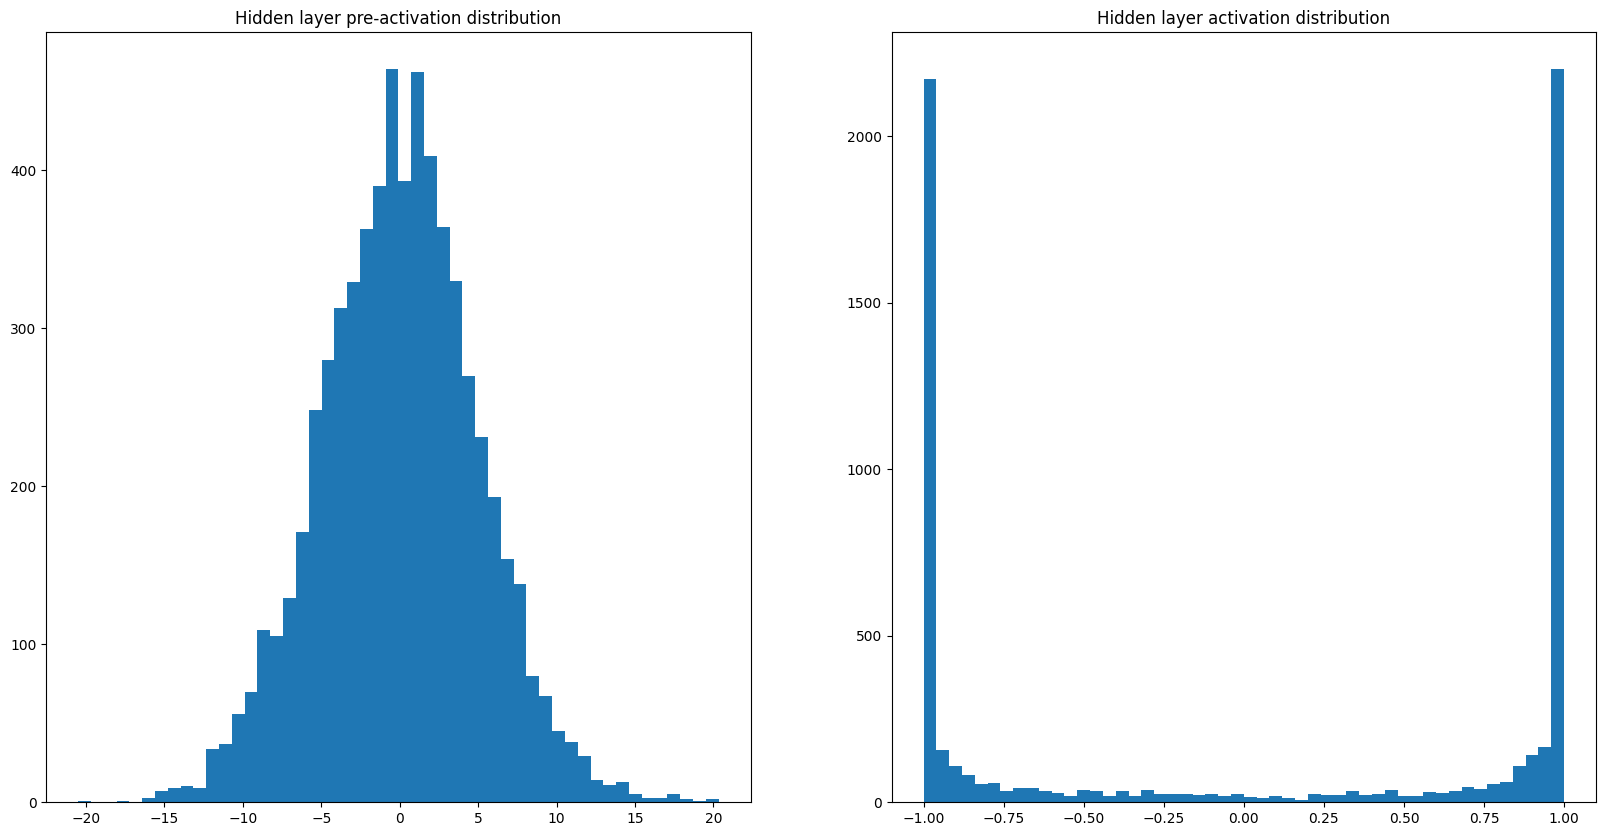

In [12]:
# Visualize saturated tanh activations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.hist(h_pre_active_init.view(-1).tolist(), bins=50)
ax1.set_title("Hidden layer pre-activation distribution")
ax2.hist(h_init.view(-1).tolist(), bins=50)
ax2.set_title("Hidden layer activation distribution")

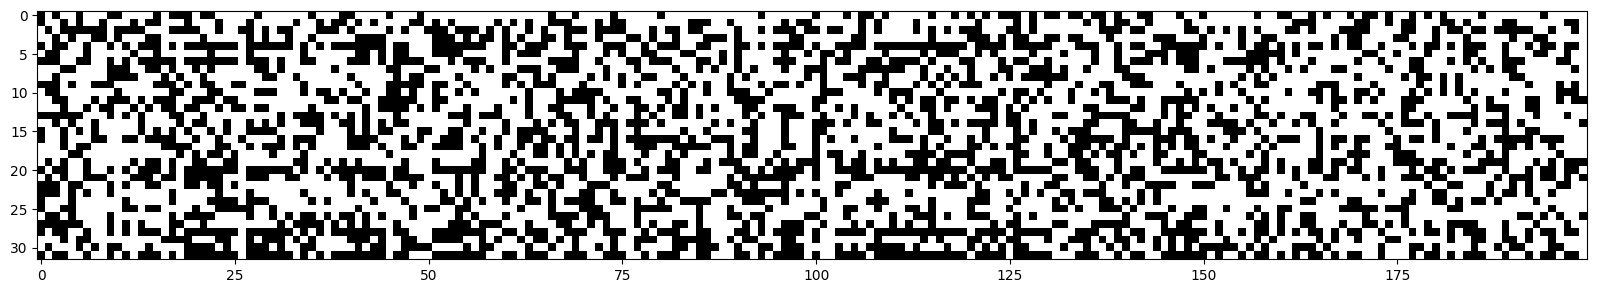

In [13]:
# Visualizing saturated hidden layer activations
plt.figure(figsize=(20,10))
plt.imshow(h_init.abs() > 0.99, cmap='gray', interpolation='nearest')
# columns of completely white pixels are dead neurons i.e. they never learn anything

In [14]:
# Model definition
rng = torch.Generator().manual_seed(seed)

## Hyperparameters
block_size = 3
embed_dim = 10
hidden_units = 200

## Parameters
### Embedding layer
C = torch.randn(len(vocab), embed_dim, generator=rng)
### Hidden layer
W1 = torch.randn(embed_dim * block_size, hidden_units, generator=rng) * 0.2  # to prevent saturating tanh neurons 
b1 = torch.randn(hidden_units, generator=rng) * 0.01  # a little bit of entropy from the bias
### Output layer
W2 = torch.randn(hidden_units, len(vocab), generator=rng) * 0.01  # non-zero for symmetry breaking
b2 = torch.zeros(len(vocab))  # squash to uniform distribution

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(f"Total number of parameters in the MLP: {sum(p.numel() for p in parameters):,}")

Total number of parameters in the MLP: 11,897


      1 / 200,000: 3.2987
 10,001 / 200,000: 2.0035
 20,001 / 200,000: 2.5984
 30,001 / 200,000: 2.1079
 40,001 / 200,000: 2.7995
 50,001 / 200,000: 2.1470
 60,001 / 200,000: 2.1489
 70,001 / 200,000: 2.6089
 80,001 / 200,000: 2.0341
 90,001 / 200,000: 2.0641
100,001 / 200,000: 2.2861
110,001 / 200,000: 2.1808
120,001 / 200,000: 1.7395
130,001 / 200,000: 1.5908
140,001 / 200,000: 1.9569
150,001 / 200,000: 1.9787
160,001 / 200,000: 1.9091
170,001 / 200,000: 1.6667
180,001 / 200,000: 2.2208
190,001 / 200,000: 2.0163


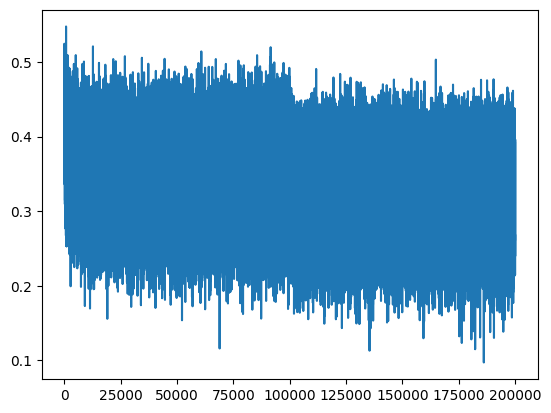

In [15]:
max_steps = 200_000
batch_size = 32

loss_train_i = []
h_pre_active_init = None
h_init = None

for i in range(max_steps):
    # Minibatch
    idx_batch = torch.randint(0, len(X_train), (batch_size,))
    X, Y = X_train[idx_batch], Y_train[idx_batch]

    # Forward pass
    embed = C[X]
    embed_concat = embed.view(len(embed), -1)
    h_pre_active = embed_concat @ W1 + b1
    h = torch.tanh(h_pre_active)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    learning_rate = 10**-0.5 if i < 100_000 else 10**-1.5
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # Track performance
    if i % 10_000 == 0:
        if i == 0:
            h_pre_active_init = h_pre_active.detach().clone()
            h_init = h.detach().clone()
        print(f"{i+1:7,d} / {max_steps:7,d}: {loss.item():.4f}")
    loss_train_i.append(loss.log10().item())

# Plot convergence
plt.plot(loss_train_i)

In [16]:
cv_split_loss('train')
cv_split_loss('val')

Train set loss: 2.1114
Val set loss: 2.1455


Text(0.5, 1.0, 'Hidden layer activation distribution')

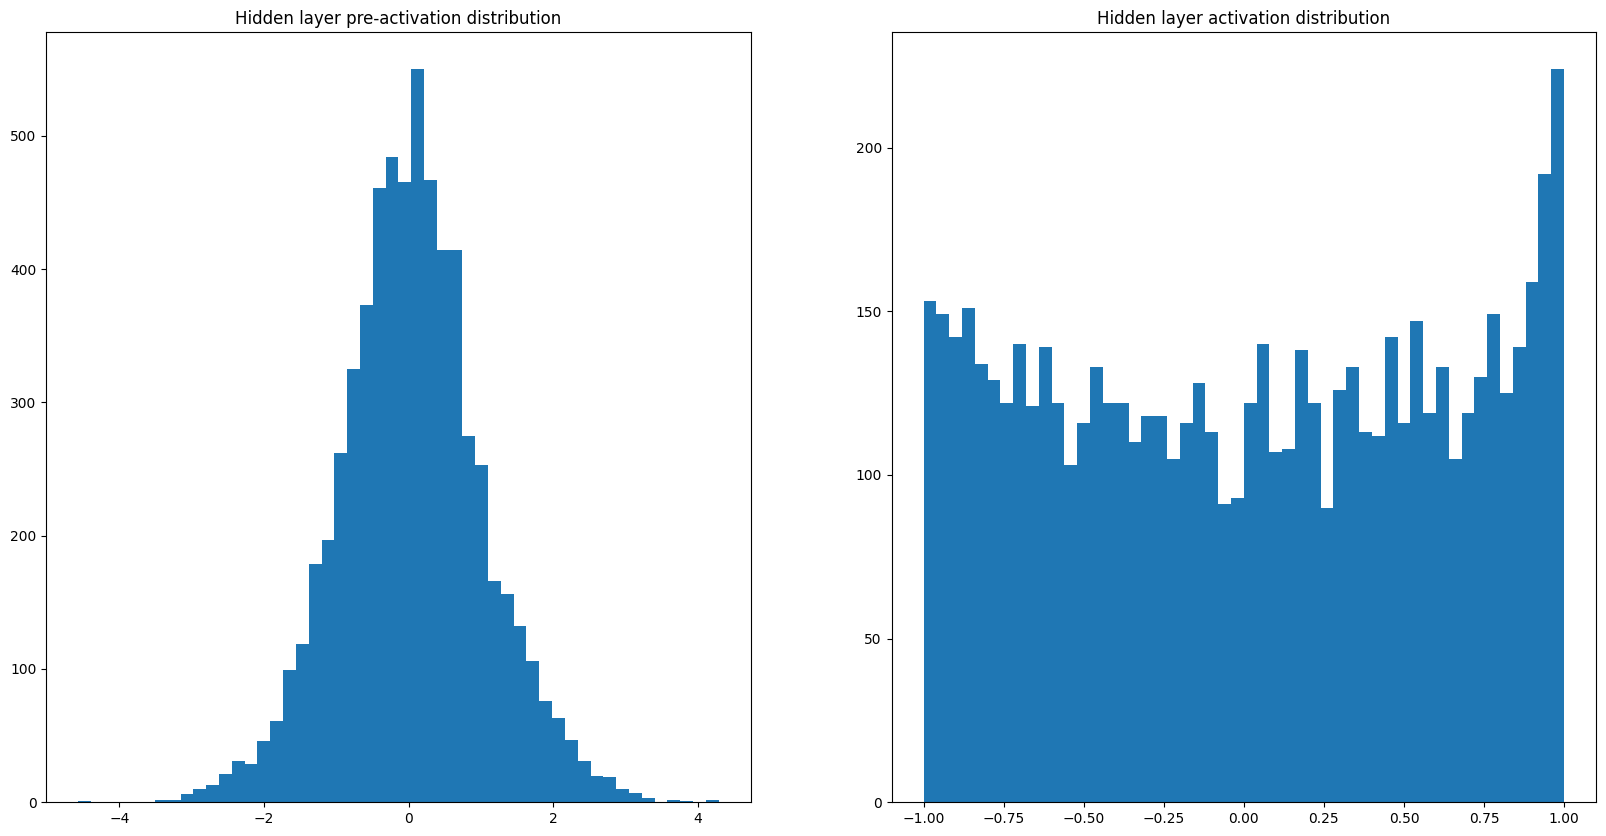

In [17]:
# Visualize less saturated tanh activations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.hist(h_pre_active_init.view(-1).tolist(), bins=50)
ax1.set_title("Hidden layer pre-activation distribution")
ax2.hist(h_init.view(-1).tolist(), bins=50)
ax2.set_title("Hidden layer activation distribution")

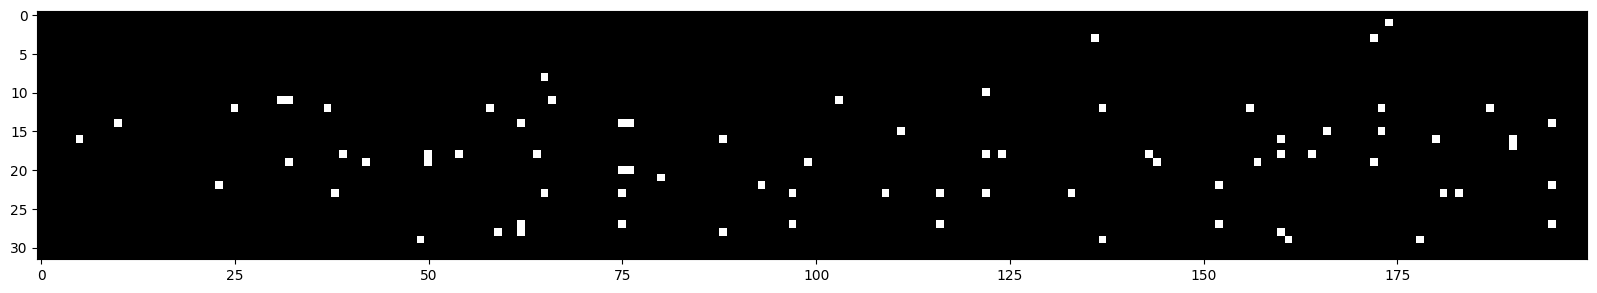

In [18]:
# Very little dead neurons
plt.figure(figsize=(20,10))
plt.imshow(h_init.abs() > 0.99, cmap='gray', interpolation='nearest')

### Kaiming He initialization
1. **Going deeper**: the initialization problem is a lot more aggravated when training deeper neural networks.
2. **Need for a principled approach**: our hacky approach above introduces many magic numbers to prevent neuron saturation and overconfidence in prediction. There are principled approaches to initializing neural networks that do not require any magic numbers.
3. **Motivation**: (see below) each time a dot product is performed between two variables that are normally distributed, their standard deviation expands considerably. This is undesirable. We want standard normal distributions to be maintained throughout the network.
4. **He initialization**: [(He et al., 2015)](https://arxiv.org/abs/1502.01852) proposed scaling the values of the weights by $\frac{1}{\sqrt{\text{fan_in}}}$, we can ensure that the output dot product remains standard normal. For ReLU activations, we can scale the weights by $\frac{2}{\sqrt{\text{fan_in}}}$. The `gain` specified in the PyTorch argument tries to counter the squashing effect of the nonlinearity. Read more: https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
    - `torch.randn()` samples a standard normal distribution i.e. it has a mean of 0 and a standard deviation of 1. Anything you multiply to it, effectively scales the standard deviation.
    - For tanh activation, He recommends the scaling factor to be $\frac{5}{3} * \frac{1}{\sqrt{\text{fan_in}}}$. Here $\text{gain} = \frac{5}{3}$. 
5. **Other techniques**: when the He paper was written, we needed to be careful of the range of values occupied by the activations/gradients with respect to the nonlinearities. Today there are many modern techniques to make the model training more stable and well-behaved e.g. residual connections, normalization layers (Batch, Layer, Group), better optimizers (RMSprop, Adam), etc. So, exact initialization is less important today.
6. **Bottomline**: normalizing the weights by $\frac{1}{\sqrt{\text{fan_in}}}$ is pretty effective.

Input: mean (-0.0072), standard deviation (1.0009).
Output: mean (0.0061), standard deviation (3.2570).
He-initialized output: mean (-0.0009), standard deviation (1.0068).


Text(0.5, 1.0, 'He-initialized output distribution')

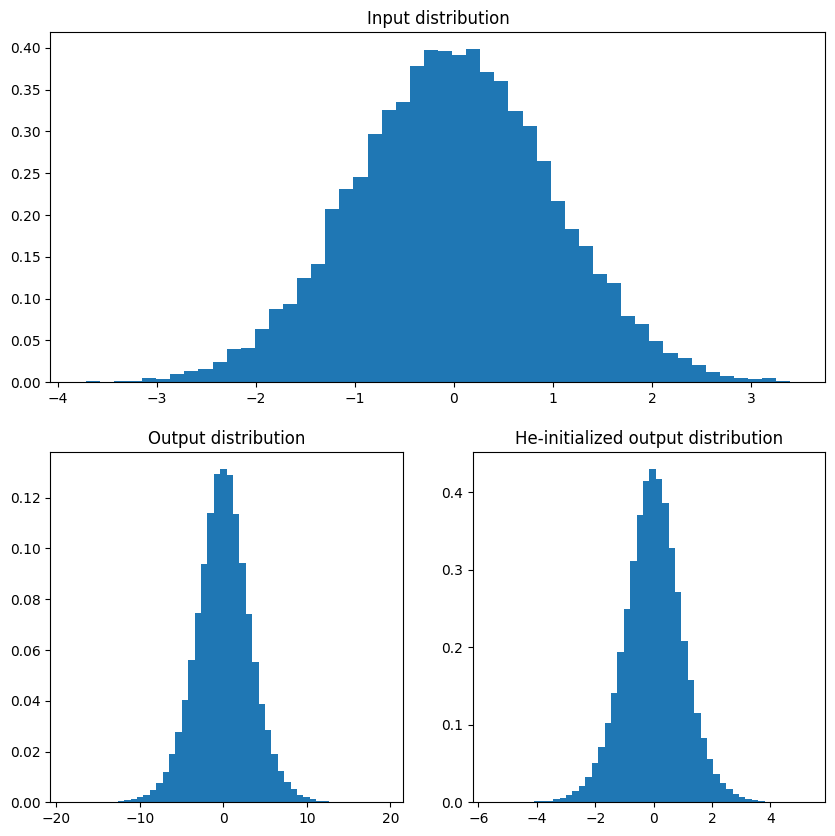

In [19]:
num_examples = 1_000
num_features = 10
X = torch.randn(num_examples, num_features)

fan_in = num_features
fan_out = 200
W = torch.randn(fan_in, fan_out) 
W_he = torch.randn(fan_in, fan_out) / torch.sqrt(torch.tensor(fan_in))  # He initialization

out = X @ W  # no bias, no activation
out_he = X @ W_he

print(f"Input: mean ({X.mean():.4f}), standard deviation ({X.std():.4f}).")
print(f"Output: mean ({out.mean():.4f}), standard deviation ({out.std():.4f}).")
print(f"He-initialized output: mean ({out_he.mean():.4f}), standard deviation ({out_he.std():.4f}).")

import matplotlib.gridspec as gridspec
_ = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2) 
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax1.hist(X.view(-1).tolist(), bins=50, density=True)
ax1.set_title("Input distribution")
ax2.hist(out.view(-1).tolist(), bins=50, density=True)
ax2.set_title("Output distribution")
ax3.hist(out_he.view(-1).tolist(), bins=50, density=True)
ax3.set_title("He-initialized output distribution")

In [20]:
# Model definition
rng = torch.Generator().manual_seed(seed)

## Hyperparameters
block_size = 3
embed_dim = 10
hidden_units = 200

## Parameters
### Embedding layer
C = torch.randn(len(vocab), embed_dim, generator=rng)
### Hidden layer
# He initialization
W1 = torch.randn(embed_dim * block_size, hidden_units, generator=rng) * (5/3) / torch.sqrt(torch.tensor(embed_dim * block_size))  
b1 = torch.randn(hidden_units, generator=rng) * 0.01  # a little bit of entropy from the bias
### Output layer
W2 = torch.randn(hidden_units, len(vocab), generator=rng) * 0.01  # non-zero for symmetry breaking
b2 = torch.zeros(len(vocab))  # squash to uniform distribution

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print(f"Total number of parameters in the MLP: {sum(p.numel() for p in parameters):,}")

Total number of parameters in the MLP: 11,897


      1 / 200,000: 3.3212
 10,001 / 200,000: 2.2651
 20,001 / 200,000: 2.2929
 30,001 / 200,000: 2.1960
 40,001 / 200,000: 2.3337
 50,001 / 200,000: 2.7897
 60,001 / 200,000: 2.3048
 70,001 / 200,000: 2.1266
 80,001 / 200,000: 2.6415
 90,001 / 200,000: 1.9207
100,001 / 200,000: 2.4913
110,001 / 200,000: 2.2519
120,001 / 200,000: 2.0661
130,001 / 200,000: 2.0416
140,001 / 200,000: 1.9780
150,001 / 200,000: 2.0350
160,001 / 200,000: 2.1132
170,001 / 200,000: 1.7640
180,001 / 200,000: 2.1059
190,001 / 200,000: 1.6243


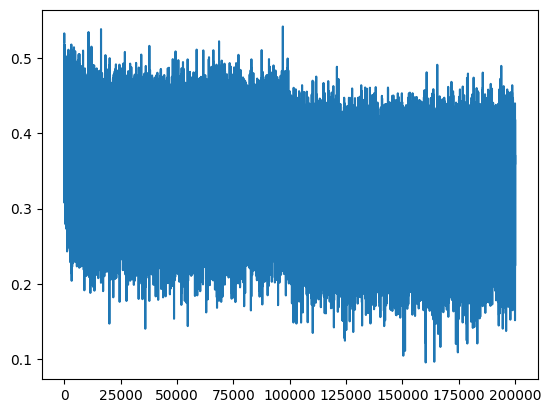

In [21]:
max_steps = 200_000
batch_size = 32

loss_train_i = []
h_pre_active_init = None
h_init = None

for i in range(max_steps):
    # Minibatch
    idx_batch = torch.randint(0, len(X_train), (batch_size,))
    X, Y = X_train[idx_batch], Y_train[idx_batch]

    # Forward pass
    embed = C[X]
    embed_concat = embed.view(len(embed), -1)
    h_pre_active = embed_concat @ W1 + b1
    h = torch.tanh(h_pre_active)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    learning_rate = 10**-0.5 if i < 100_000 else 10**-1.5
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # Track performance
    if i % 10_000 == 0:
        if i == 0:
            h_pre_active_init = h_pre_active.detach().clone()
            h_init = h.detach().clone()
        print(f"{i+1:7,d} / {max_steps:7,d}: {loss.item():.4f}")
    loss_train_i.append(loss.log10().item())

# Plot convergence
plt.plot(loss_train_i)

In [22]:
cv_split_loss('train')
cv_split_loss('val')

Train set loss: 2.0844
Val set loss: 2.1317


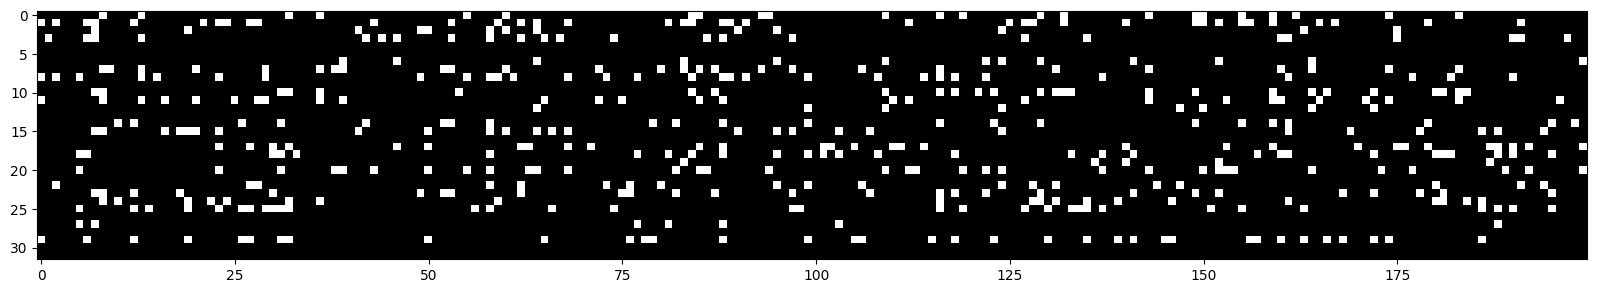

In [23]:
plt.figure(figsize=(20,10))
plt.imshow(h_init.abs() > 0.99, cmap='gray', interpolation='nearest')

## Batch normalization
1. [(Ioffe et al., 2015)](https://arxiv.org/abs/1502.03167) introduced batch normalization that allowed reliably training deep neural networks.
2. **Motivation**: we don't want activations to be too small else `tanh` would do nothing and let the gradients pass through unaltered. We also don't want activations to be too large else `tanh` would saturate and kill the gradients. Batch normalization helps us keep the activations in the sweet spot. We want the activations to be fairly standard normal.
3. **Batch Normalization**: if you want activations to be standard normal, why not just standardize them directly? 
    - **Mean, variance**: first calculate the mini-batch mean and variance for each neuron.
    - **Normalize/standardize**: next, normalize/standardize the activations by subtracting the mean and dividing by the standard deviation.
    - **Scale and shift**: finally, scale and shift the activations by learnable parameters $\gamma$ and $\beta$. These are called affine parameters in PyTorch.
    - **Batch**: This normalizes the activations within the batch. 
    - **BatchNorm as a regularizer**: BatchNorm is a regularizer because it adds noise to the activations by making them jitter due to variations in different minibatches. This is because the mean and variance are calculated over the mini-batch.
    - **Trivial bias**: the layer preceding the BatchNorm layer has no need for the bias term because BatchNorm removes the bias when it subtracts the mean activation $\mu_{\mathcal{B}}$, and to compensate, it provides a learnable bias term $\beta$.  

$$
\mu_{\mathcal{B}} = \frac{1}{m} \sum_{i=1}^m x_i \qquad \sigma_{\mathcal{B}}^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_{\mathcal{B}})^2 \qquad \hat{x}_i = \frac{x_i - \mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^2 + \epsilon}}
$$

$$
y_i = \gamma \hat{x}_i + \beta
$$

4. **When to use?**: Batch normalization becomes all the more important for deeper and more complex neural networks. Including when residual connections are added. Usually after the linear layer just before the nonlinearity. It is now customary to add BatchNorm after every convolutional layer and before every activation function.
5. **Inference**: During inference, we don't have a mini-batch. We use the training set mean and variance instead of the mini-batch mean and variance. This is because we want the inference to be deterministic. We don't want the inference to be different for different runs. We want the inference to be the same for the same input. 
    - **Momentum**: set a large momentum when the batch size is large and the mean and standard deviation does not change much between mini-batches. Set a small momentum when the batch size is small and the mean and standard deviation changes a lot between mini-batches. 
    - **Track running stats**: if you are applying the model on a different population distribution than the training set, then do not track the running mean and standard deviation. Instead, calculate on the reference dataset depicting the new population. 
6. **Alternatives**: Batch normalization has an undesirable property of mathematically combining the examples within a batch. The examples within a batch are no longer independent. This is especially bad for small batch sizes. It is a source of many bugs and unexpected behaviors. The regularizing effect is both a boon and a bane. The other alternatives below aren't as effective due to BatchNorm's regularizing effect.
    - [(Ioffe et al., 2017)](https://arxiv.org/abs/1705.07832) introduced layer normalization that normalizes the activations within a layer instead of within a batch. 
    - [(Ba et al., 2016)](https://arxiv.org/abs/1607.06450) introduced instance normalization that normalizes the activations within a channel instead of within a batch. 
    - [(Ulyanov et al., 2016)](https://arxiv.org/abs/1607.08022) introduced group normalization that normalizes the activations within a group of channels instead of within a batch. 
    - [(Wu et al., 2018)](https://arxiv.org/abs/1803.08494) introduced switchable normalization that allows the user to switch between batch normalization, layer normalization, instance normalization, and group normalization. 
    - [(Huang et al., 2018)](https://arxiv.org/abs/1805.08318) introduced spectral normalization that normalizes the weights of a layer instead of the activations.

In [24]:
# Model definition
rng = torch.Generator().manual_seed(seed)

## Hyperparameters
block_size = 3
embed_dim = 10
hidden_units = 200

## Parameters
### Embedding layer
C = torch.randn(len(vocab), embed_dim, generator=rng)
### Hidden layer
#### He initialization with batch normalization
W1 = torch.randn(embed_dim * block_size, hidden_units, generator=rng) * (5/3) / torch.sqrt(torch.tensor(embed_dim * block_size))  
# b1 = torch.randn(hidden_units, generator=rng) * 0.01  # removed due to batch normalization
bn_mean_running = torch.zeros((1, hidden_units))  # running mean
bn_std_running = torch.ones((1, hidden_units))  # running standard deviation
bn_gamma = torch.ones((1, hidden_units))  # scale
bn_beta = torch.zeros((1, hidden_units))  # shift
### Output layer
W2 = torch.randn(hidden_units, len(vocab), generator=rng) * 0.01  # non-zero for symmetry breaking
b2 = torch.zeros(len(vocab))  # squash to uniform distribution

parameters = [C, W1, bn_gamma, bn_beta, W2, b2]  # no gradients for running mean and standard deviation
for p in parameters:
    p.requires_grad = True
print(f"Total number of parameters in the MLP: {sum(p.numel() for p in parameters):,}")

Total number of parameters in the MLP: 12,097


      1 / 200,000: 3.2927
 10,001 / 200,000: 2.6575
 20,001 / 200,000: 2.6589
 30,001 / 200,000: 2.0142
 40,001 / 200,000: 2.1609
 50,001 / 200,000: 2.0517
 60,001 / 200,000: 2.0202
 70,001 / 200,000: 2.2669
 80,001 / 200,000: 2.4145
 90,001 / 200,000: 2.9201
100,001 / 200,000: 2.0241
110,001 / 200,000: 2.1772
120,001 / 200,000: 2.0364
130,001 / 200,000: 2.1004
140,001 / 200,000: 2.3545
150,001 / 200,000: 2.1943
160,001 / 200,000: 1.8556
170,001 / 200,000: 2.0985
180,001 / 200,000: 2.2206
190,001 / 200,000: 2.1762


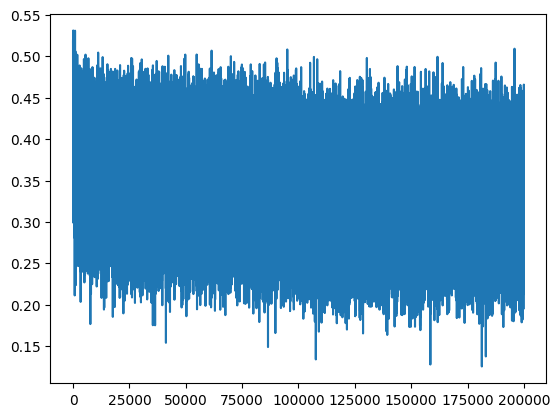

In [25]:
max_steps = 200_000
batch_size = 32

loss_train_i = []
h_pre_active_init = None
h_init = None

for i in range(max_steps):
    # Minibatch
    idx_batch = torch.randint(0, len(X_train), (batch_size,))
    X, Y = X_train[idx_batch], Y_train[idx_batch]

    # Forward pass
    embed = C[X]
    embed_concat = embed.view(len(embed), -1)
    h_pre_active = embed_concat @ W1 #+ b1
    h_mean = h_pre_active.mean(dim=0, keepdim=True)  # mean activation of each neuron, over all batch examples
    h_std = h_pre_active.std(dim=0, keepdim=True)  # std activation of each neuron, over all batch examples
    h_pre_active_bn = bn_gamma * ((h_pre_active - h_mean) / h_std) + bn_beta  # batch normalization
    
    # mean and std for inference
    with torch.no_grad():  
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * h_mean
        bn_std_running = 0.999 * bn_std_running + 0.001 * h_std
        
    h = torch.tanh(h_pre_active_bn)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    learning_rate = 10**-0.5 if i < 100_000 else 10**-1.5
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # Track performance
    if i % 10_000 == 0:
        if i == 0:
            h_pre_active_init = h_pre_active.detach().clone()
            h_init = h.detach().clone()
        print(f"{i+1:7,d} / {max_steps:7,d}: {loss.item():.4f}")
    loss_train_i.append(loss.log10().item())

# Plot convergence
plt.plot(loss_train_i)

In [26]:
@torch.no_grad()  # disable gradient tracking; alternative to `with torch.no_grad():`
def cv_split_loss(split_name='train'):
    X, Y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split_name]
    
    embed = C[X]
    embed_concat = embed.view(len(embed), -1)
    h_pre_active = embed_concat @ W1 #+ b1
    h_pre_active_bn = bn_gamma * ((h_pre_active - bn_mean_running) / bn_std_running) + bn_beta  # batch normalization
    h = torch.tanh(h_pre_active_bn)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    
    print(f"{split_name.capitalize()} set loss: {loss.item():.4f}")

In [27]:
cv_split_loss('train')
cv_split_loss('val')

Train set loss: 2.1411
Val set loss: 2.1624


## Network calibration diagnostics

Visualize and diagnose poorly calibrated networks and fix them using He initialization, gain, and batch normalization.

In [28]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.W = torch.randn((in_features, out_features), generator=rng) / torch.sqrt(torch.tensor(in_features))  # He initialization
        self.b = torch.zeros(out_features) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])


class BatchNorm1d:
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # running mean and variance
        self.mean_running = torch.zeros(num_features)
        self.var_running = torch.ones(num_features)
        # affine transformation parameters
        self.gamma = torch.ones(num_features)  # scale
        self.beta = torch.zeros(num_features)  # shift
    
    def __call__(self, x):
        if self.training:
            # batch mean and variance
            mean = x.mean(dim=0, keepdim=True)
            var = x.var(dim=0, keepdim=True)
            # update running mean and variance
            with torch.no_grad():
                self.mean_running = (1 - self.momentum) * self.mean_running + self.momentum * mean 
                self.var_running = (1 - self.momentum) * self.var_running + self.momentum * var 
        else:
            # use running mean and variance
            mean = self.mean_running
            var = self.var_running
        
        # normalize
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        # scale and shift
        self.out = self.gamma * x_hat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [29]:
# Model definition
rng = torch.Generator().manual_seed(seed)

## Hyperparameters
block_size = 3
embed_dim = 10
hidden_units = 100

## Layers
C = torch.randn(len(vocab), embed_dim, generator=rng)
layers = [
    Linear(block_size * embed_dim, hidden_units), BatchNorm1d(hidden_units), Tanh(),
    Linear(hidden_units, hidden_units), BatchNorm1d(hidden_units), Tanh(),
    Linear(hidden_units, hidden_units), BatchNorm1d(hidden_units), Tanh(),
    Linear(hidden_units, hidden_units), BatchNorm1d(hidden_units), Tanh(),
    Linear(hidden_units, hidden_units), BatchNorm1d(hidden_units), Tanh(),
    Linear(hidden_units, len(vocab)), BatchNorm1d(len(vocab)),
]

## Initial weights
with torch.no_grad():
    # for the overconfidence problem
    # layers[-1].W *= 0.1
    layers[-1].gamma *= 0.1  # when using BatchNorm1d
    
    # apply tanh gain; for the neuron saturation problem
    for l in layers:
        if isinstance(l, Linear):
            # counter the squashing effect of tanh; 5/3 stabilizes the initial std
            # if the value is too low, the later layers will start peaking due to tanh
            # if the value is too high, there will be high saturation
            # 5/3 is the Goldilocks value for tanh
            l.W *= 5/3  # try 0.5, 1, 5/3, and 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Number of parameters: {sum(p.numel() for p in parameters):,}")

for p in parameters:
    p.requires_grad = True

Number of parameters: 47,551


In [30]:
max_steps = 200_000
batch_size = 32

loss_train_i = []
update_data_ratio = []

for i in range(max_steps):
    # Minibatch
    idx_batch = torch.randint(0, len(X_train), (batch_size,))
    X, Y = X_train[idx_batch], Y_train[idx_batch]

    # Forward pass
    embed = C[X]
    x = embed.view(len(embed), -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y)
    
    # Backward pass
    for layer in layers:
        layer.out.retain_grad()  # keep gradients of outputs
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient update
    learning_rate = 1e-1 if i < 100_000 else 1e-2
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # Track performance
    if i % 10_000 == 0:
        print(f"{i+1:7,d} / {max_steps:7,d}: {loss.item():.4f}")
    loss_train_i.append(loss.log10().item())
    with torch.no_grad():
        update_data_ratio.append(
            [((learning_rate * p.grad.std()) / p.data.std()).log10().item() for p in parameters])
    
    # Halt training
    if i == 1_000:
        break

# Plot convergence
#plt.plot(loss_train_i)

      1 / 200,000: 3.3335


Visualize the activations to ensure:
- Should be uniformly distributed at the beginning.
- There should be an even distribution of activations across layers. Monitor the 1st and 2nd moments. Monitor the density plots.
- There should be little to no saturation of neurons.

Forward pass activation distribution - layer by layer
-----------------------------------------------------
Tanh Layer #2: mean=7.14e-03, std=6.29e-01, saturation=3.16%
Tanh Layer #5: mean=-5.63e-05, std=6.36e-01, saturation=2.50%
Tanh Layer #8: mean=-4.38e-03, std=6.39e-01, saturation=2.69%
Tanh Layer #11: mean=8.50e-04, std=6.42e-01, saturation=2.12%
Tanh Layer #14: mean=-2.78e-03, std=6.46e-01, saturation=1.69%


Text(0.5, 1.0, 'Forward pass activation distribution')

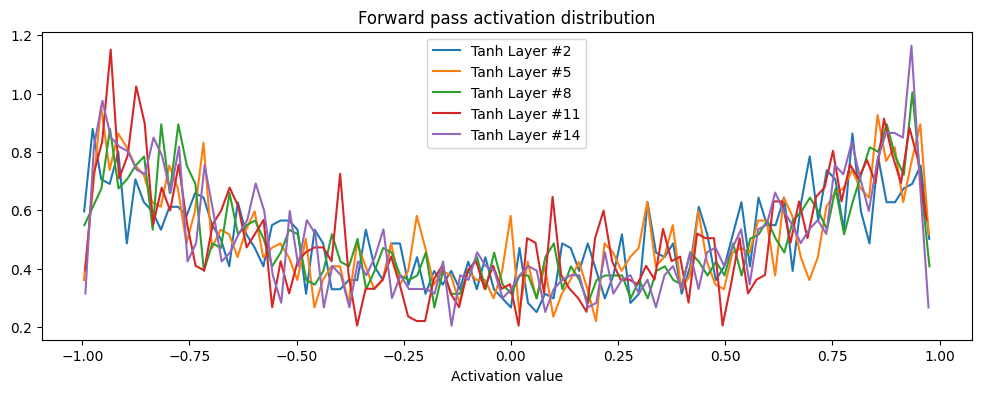

In [31]:
# Plot activations 
plt.figure(figsize=(12, 4))
legends = []

print("Forward pass activation distribution - layer by layer")
print("-----------------------------------------------------")
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        out = layer.out
        mean = out.mean().item()
        std = out.std().item()
        saturation = (out.abs() > 0.97).float().mean() * 100
        print(f"{layer.__class__.__name__} Layer #{i}: mean={mean:.2e}, std={std:.2e}, saturation={saturation:.2f}%")
        bin_density, bin_edges = torch.histogram(out, density=True)
        plt.plot(bin_edges[:-1].detach(), bin_density.detach())
        legends.append(f"{layer.__class__.__name__} Layer #{i}")

plt.legend(legends)
plt.xlabel("Activation value")
plt.title("Forward pass activation distribution")

Visualize the gradients to ensure:
- $\mathcal{N}\sim(1-\mathcal{U}[-1, 1])^2$
- All layers have similarly distributed gradients.
- Deeper layers gradients don't start vanishing or exploding.

Backward pass tanh gradient distribution - layer by layer
---------------------------------------------------------
Tanh Layer #2: mean=2.91e-12, std=3.14e-03
Tanh Layer #5: mean=-3.49e-12, std=2.79e-03
Tanh Layer #8: mean=1.75e-12, std=2.47e-03
Tanh Layer #11: mean=-4.07e-12, std=2.38e-03
Tanh Layer #14: mean=7.57e-12, std=2.36e-03


Text(0.5, 1.0, 'Backward pass tanh gradient distribution')

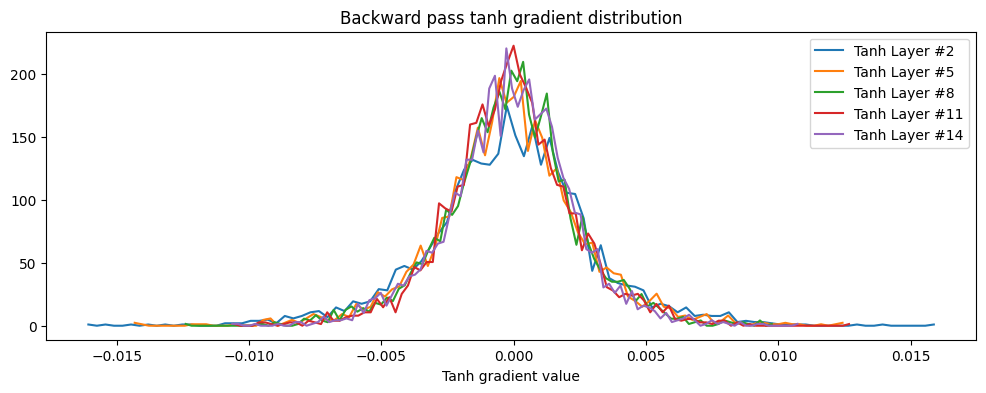

In [32]:
# Plot gradients 
plt.figure(figsize=(12, 4))
legends = []

print("Backward pass tanh gradient distribution - layer by layer")
print("---------------------------------------------------------")
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        out = layer.out.grad
        mean = out.mean().item()
        std = out.std().item()
        print(f"{layer.__class__.__name__} Layer #{i}: mean={mean:.2e}, std={std:.2e}")
        bin_density, bin_edges = torch.histogram(out, density=True)
        plt.plot(bin_edges[:-1].detach(), bin_density.detach())
        legends.append(f"{layer.__class__.__name__} Layer #{i}")

plt.legend(legends)
plt.xlabel("Tanh gradient value")
plt.title("Backward pass tanh gradient distribution")

Visualize the weight gradients to ensure:
- The logit layer is uniformly distributed but other layers are normally distributed.
- The scale of the gradient isn't too large compared to the scale of the activation values. Otherwise, the gradient update will be too large and the model will diverge.
- If the scale of the standard deviation of a layer is off by a factor compared to the other layers, that layer will be updated at a rate proportional to that factor. We made the last layer uniform, that gave it a standard deviation that is higher by a factor of 100. So, the last layer learns much faster than the other layers.

Weights gradient distribution - parameter by parameter
------------------------------------------------------
Weight (27, 10): mean=2.21e-10, std=8.68e-03, grad:data=8.84e-03
Weight (30, 100): mean=-7.53e-05, std=7.10e-03, grad:data=2.28e-02
Weight (100, 100): mean=8.93e-05, std=6.16e-03, grad:data=3.70e-02
Weight (100, 100): mean=3.74e-06, std=4.98e-03, grad:data=2.94e-02
Weight (100, 100): mean=-1.07e-05, std=4.59e-03, grad:data=2.75e-02
Weight (100, 100): mean=-1.69e-05, std=4.45e-03, grad:data=2.64e-02
Weight (100, 27): mean=-8.87e-06, std=8.36e-03, grad:data=5.00e-02


Text(0.5, 1.0, 'Weights gradient distribution')

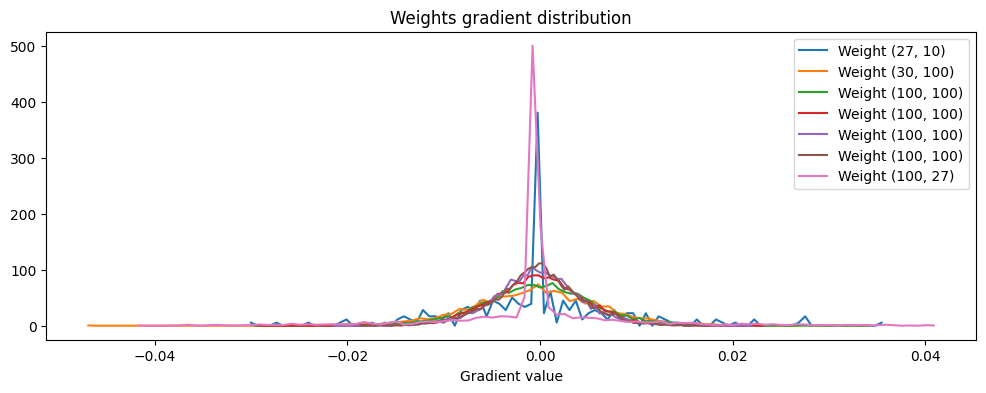

In [33]:
# Plot weight gradients
plt.figure(figsize=(12, 4))
legends = []

print("Weights gradient distribution - parameter by parameter")
print("------------------------------------------------------")
for i, p in enumerate(parameters):
    if p.ndim == 2:
        mean = p.grad.mean().item()
        std = p.grad.std().item()
        grad_data_ratio = p.grad.std() / p.std()  # gradient/weight scale ratio
        print(f"Weight {tuple(p.shape)}: mean={mean:.2e}, std={std:.2e}, grad:data={grad_data_ratio:.2e}")
        bin_density, bin_edges = torch.histogram(p.grad, density=True)
        plt.plot(bin_edges[:-1].detach(), bin_density.detach())
        legends.append(f"Weight {tuple(p.shape)}")

plt.legend(legends)
plt.xlabel("Gradient value")
plt.title("Weights gradient distribution")

The above gradient/activation scale ratio was not very illustrative. Instead of taking $\frac{\nabla x}{x}$, we can plot $\frac{\alpha\cdot\nabla x}{x}$ over each iteration of optimization.
Explore the effect of different learning rates on this plot.
- If the learning rate is too low, most of the update/weight ratio will be below -3.
- If the learning rate is too high, most of the update/weight ratio will be above -3.
- Identify which weights are not being updated at a good pace.
- Diagnose if the different layers are learning at a different pace.

Text(0.5, 1.0, 'Update/weight scale ratio over iterations')

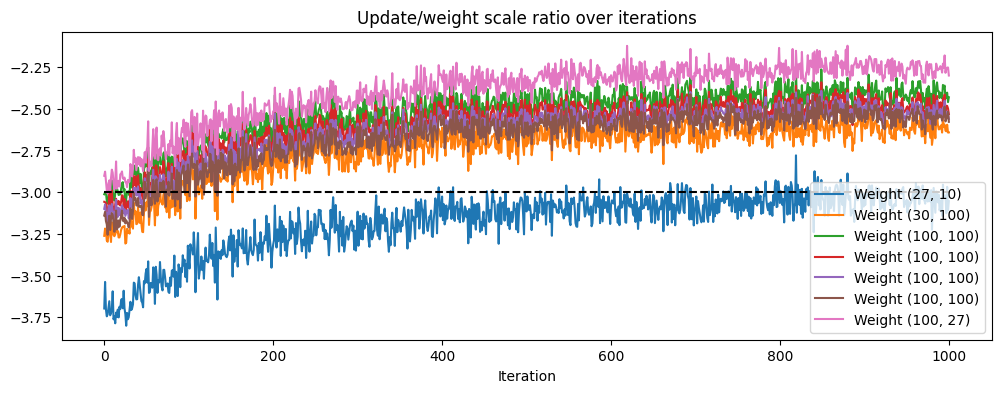

In [34]:
plt.figure(figsize=(12, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([update_data_ratio[j][i] for j in range(len(update_data_ratio))])
        legends.append(f"Weight {tuple(p.shape)}")

# weight is 1e3 times larger than gradient
# weights below are learning too slowly; weights far above are learning too fast
plt.plot([0, len(update_data_ratio)], [-3, -3], "k--")

plt.legend(legends)
plt.xlabel("Iteration")
plt.title("Update/weight scale ratio over iterations")

## Takeaways
- Without batch normalization, the activations and gradients are too sensitive to initialization (gain).
- Initialization without batch normalization:
    - He initialization alone is not enough. Gain is important to monitor.
    - Each activation (or its absence) has a different gain value that stabilizes the distribution of activations across layers. This is because the gain value compensates for the squashing effect of the activation.
    - The neural network is very sensitive to this gain value.
    - Uneven distribution of activations/gradients (e.g. vanishing/exploding gradients) across layers, large number of saturated neurons, etc. are indicators of a bad gain value.
- Techniques like batch normalization, residual connections, and Adam optimization has made it easier to train neural networks by ensuring robustness. It is now less sensitive to initialization. 
- Why are nonlinear activations necessary? If you don't add nonlinearity, the sequence of linear transformation layers behave as a single linear transformation. So, it cannot model nonlinear relationships in the data.